In [9]:


#rcParams['savefig.dpi'] = 75

#from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib.pylab import *
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event
from sigvisa.signals.io import fetch_waveform, EventNotDetected, MissingWaveform
from sigvisa.models.ttime import tt_predict
from sigvisa.ssms_c import CompactSupportSSM

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.infer.optimize.optim_utils import construct_optim_params
from sigvisa.plotting.plot import plot_det_times, plot_pred_atimes
from sigvisa.database.dataset import read_evids_detected_at_station, read_event_detections, DET_TIME_COL

from sigvisa.graph.load_sigvisa_graph import load_sg_from_db_fit
from sigvisa.models.wiggles.wavelets import construct_full_basis_implicit

In [10]:
print "hello world"

hello world


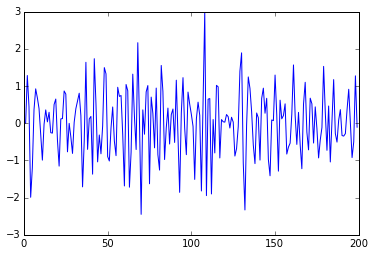

In [59]:
from sigvisa.database.signal_data import *

bc = construct_full_basis_implicit(wavelet_str="db4_2.0_3_20.0", srate=10, c_format=True)
(start_idxs, end_idxs, identities, basis_prototypes, levels, N) = bc

#messages = read_messages("663033.msg", 18)
wavelet_means = messages["db4_2.0_3_20.0_posterior"][0]
wavelet_vars = np.ones(wavelet_means.shape) * 1e-6

def cumulative_means(base_means, levels, level):
    cmeans = np.zeros(base_means.shape)
    ncoefs = np.sum(levels[:level+1])
    cmeans[:ncoefs] = base_means[:ncoefs]
    return cmeans

cmeans = cumulative_means(wavelet_means, levels, 3)
cssm = CompactSupportSSM(start_idxs, end_idxs, identities, basis_prototypes, cmeans, wavelet_vars, 0.0, 0.0)
s = cssm.mean_obs(N)
plt.plot(s)

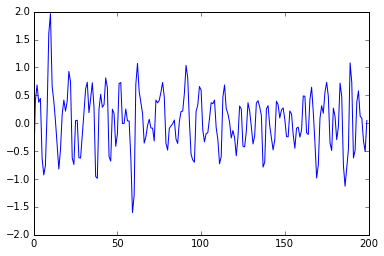

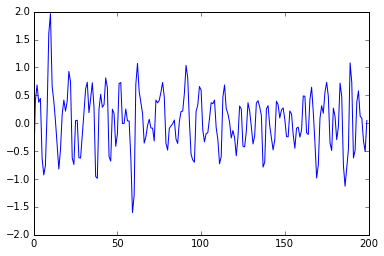

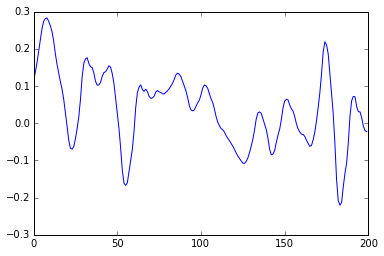

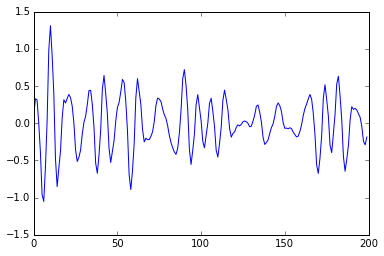

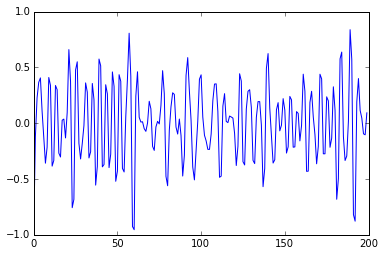

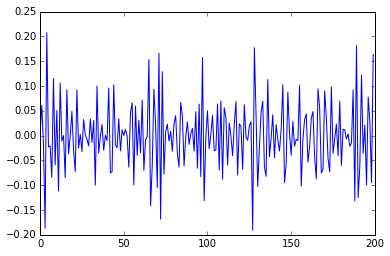

In [60]:
bc = construct_full_basis_implicit(wavelet_str="db4_2.0_3_20.0", srate=10, c_format=True)
(start_idxs, end_idxs, identities, basis_prototypes, levels, N) = bc


def sample_signal(level_vars, seed=1):
    prior_vars = []
    for i, lsize in enumerate(levels):
        prior_vars += [level_vars[i],] * lsize
    prior_vars = np.array(prior_vars)
    prior_means = np.zeros(prior_vars.shape)

    cssm = CompactSupportSSM(start_idxs, end_idxs, identities, basis_prototypes, prior_means, prior_vars, 0.0, 0.0)

    s = cssm.prior_sample(N, seed)
    return s

seed=2
s = sample_signal([0.1, 1.0, 0.5, 0.01], seed=seed)
s1 = sample_signal([0.1, 0.0, 0.0, 0.0], seed=seed)
s2 = sample_signal([0.0, 1.0, 0.0, 0.0], seed=seed)
s3 = sample_signal([0.0, 0.0, 0.5, 0.0], seed=seed)
s4 = sample_signal([0.0, 0.0, 0.0, 0.01], seed=seed)
plt.plot(s)
plt.figure()
plt.plot(s1+s2+s3+s4)
plt.figure()
plt.plot(s1)
plt.figure()
plt.plot(s2)
plt.figure()
plt.plot(s3)
plt.figure()
plt.plot(s4)

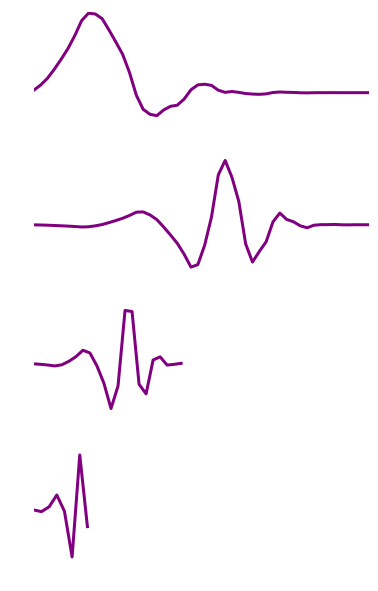

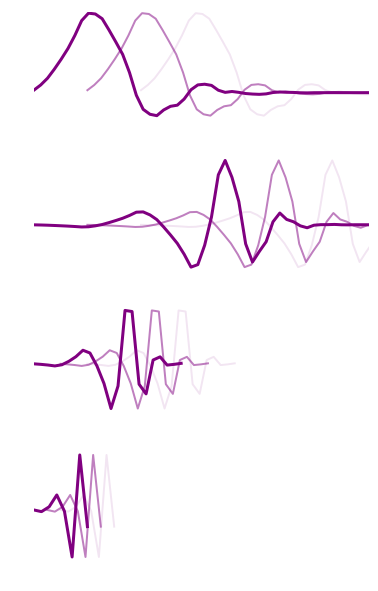

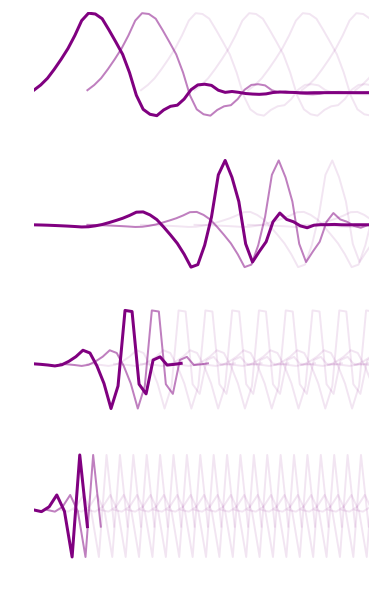

In [76]:
srate=10.0
x = np.linspace(0, 20, 200)

b = construct_full_basis_implicit(wavelet_str="db4_2.0_3_20.0", srate=10, c_format=False)
(start_idxs, end_idxs, identities, basis_prototypes, levels, N) = b




total_len = 5.0

def plot_level(level, ax, max_repeats=100):
    b = basis_prototypes[level]
    baseidx = int(np.sum(levels[:level]))
    skip = start_idxs[baseidx+1] - start_idxs[baseidx]
    skip_s = skip / srate
    
    xb = np.linspace(0*skip_s, 0*skip_s + len(b)/srate, len(b))
    ax.plot(xb, b, linewidth=3, color="purple")
    
    if max_repeats > 1:
        xb = np.linspace(1*skip_s, 1*skip_s + len(b)/srate, len(b))
        ax.plot(xb, b, linewidth=2, color="purple", alpha=0.5)
    
    i = 2
    while (i <= max_repeats) and i * skip_s < total_len:
        xb = np.linspace(i*skip_s, i*skip_s + len(b)/srate, len(b))
        ax.plot(xb, b, linewidth=2, color="purple", alpha=0.1)
        i += 1
    ax.set_xlim(0, total_len)



def plot_hierarchy(f, max_repeats):
    ax = f.add_subplot(411)
    plot_level(0, ax, max_repeats=max_repeats)
    ax.axis('off')

    ax = f.add_subplot(412, sharex=ax)
    plot_level(1, ax, max_repeats=max_repeats)
    ax.axis('off')

    ax = f.add_subplot(413, sharex=ax)
    plot_level(2, ax, max_repeats=max_repeats)
    ax.axis('off')

    ax = f.add_subplot(414, sharex=ax)
    plot_level(3, ax, max_repeats=max_repeats)
    ax.axis('off')
    
f = plt.figure(figsize=(6, 10))
plot_hierarchy(f, 1)

f = plt.figure(figsize=(6, 10))
plot_hierarchy(f, 2)

f = plt.figure(figsize=(6, 10))
plot_hierarchy(f, 100)

In [37]:
print start_idxs

[-42, -34, -26, -18, -10, -2, 6, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 102, 110, 118, 126, 134, 142, 150, 158, 166, 174, 182, 190, 198, -42, -34, -26, -18, -10, -2, 6, 14, 22, 30, 38, 46, 54, 62, 70, 78, 86, 94, 102, 110, 118, 126, 134, 142, 150, 158, 166, 174, 182, 190, 198, -18, -14, -10, -6, -2, 2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114, 118, 122, 126, 130, 134, 138, 142, 146, 150, 154, 158, 162, 166, 170, 174, 178, 182, 186, 190, 194, 198, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198]
